In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
from nltk.metrics.distance import edit_distance

from textwrap import wrap

In [2]:
MISSING = " "

# Etape 1 - Scrapping chart

In [7]:
#Load
charts = pd.read_csv("../etapes/1 - scrapping chart/charts.csv", encoding="utf-8-sig")

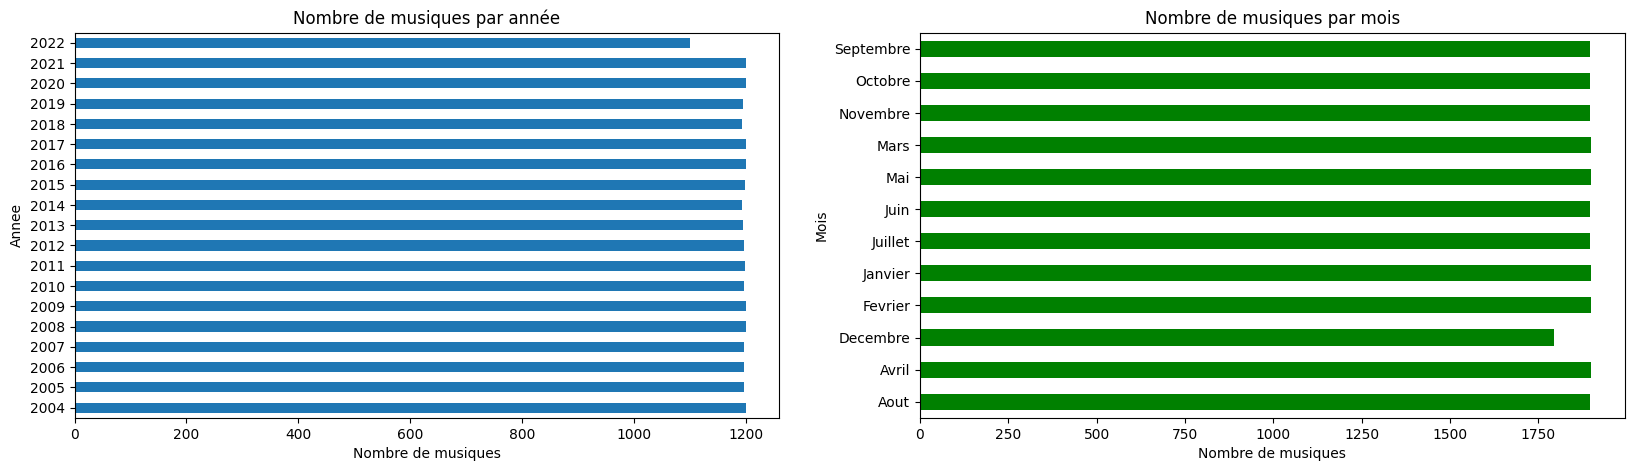

In [58]:
#Donnée par année
fig, ax = plt.subplots(1, 2, figsize=(20,5))
charts.groupby("Annee")["Music"].count().plot.barh(ax=ax[0])
ax[0].set(title="Nombre de musiques par année", xlabel="Nombre de musiques")

charts.groupby("Mois")["Music"].count().plot.barh(ax=ax[1], color="green")
ax[1].set(title="Nombre de musiques par mois", xlabel="Nombre de musiques")

plt.show()

# Etape 2 - Cleanning chart

In [58]:
#Load
charts = pd.read_csv("../etapes/2 - cleanning chart/charts.csv", encoding="utf-8-sig")

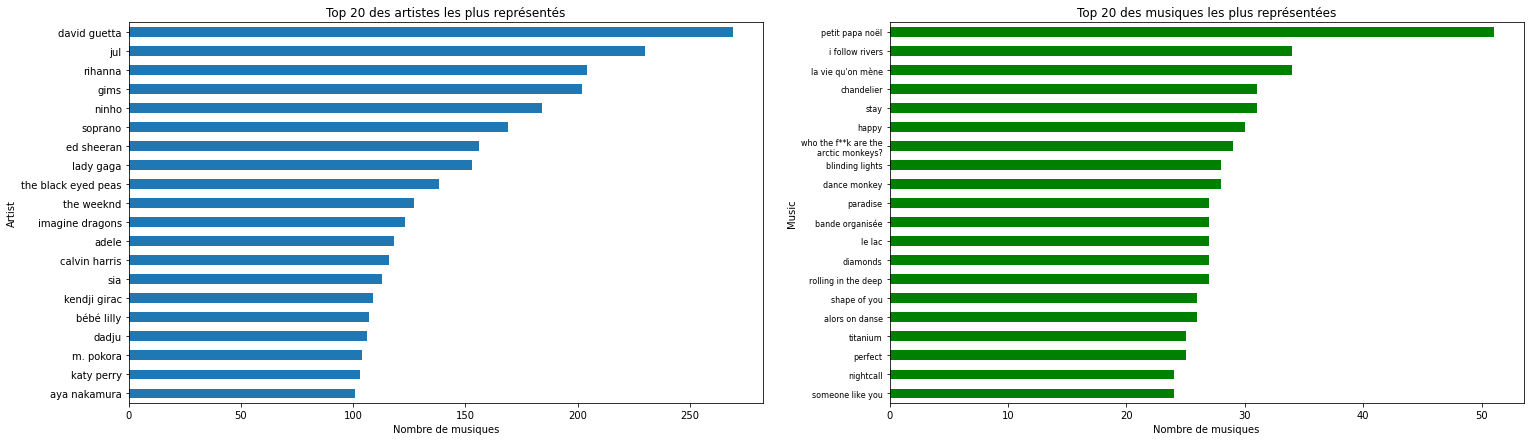

In [59]:
fig, ax = plt.subplots(1, 2, figsize=(25,7))
charts.groupby("Artist")["Music"].count().sort_values()[-20:].plot.barh(ax=ax[0])
ax[0].set(title="Top 20 des artistes les plus représentés", xlabel="Nombre de musiques")

charts.groupby("Music")["Artist"].count().sort_values()[-20:].plot.barh(ax=ax[1], color="green")
ax[1].set(title="Top 20 des musiques les plus représentées", xlabel="Nombre de musiques")
ax[1].set_yticklabels(["\n".join(wrap(elem.get_text(), 20)) for elem in ax[1].get_yticklabels()], size=8)

plt.show()

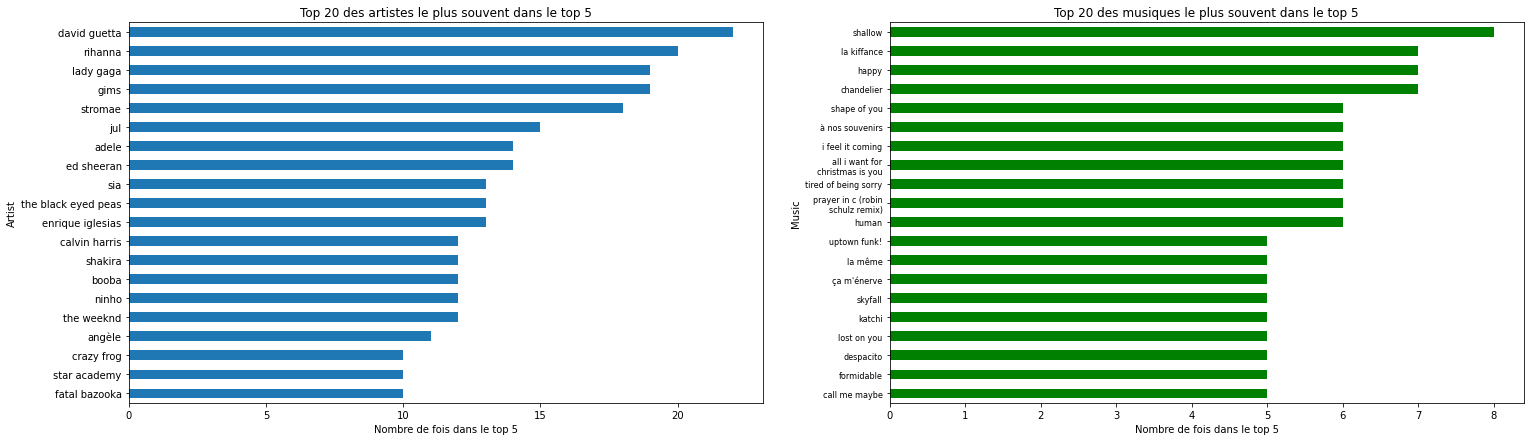

In [69]:
top = 5

fig, ax = plt.subplots(1, 2, figsize=(25,7))
charts.groupby("Artist")["Rank"].value_counts().unstack().iloc[:, :top].sum(axis=1).sort_values()[-20:].plot.barh(ax=ax[0])
ax[0].set(title=f"Top 20 des artistes le plus souvent dans le top {top}", xlabel=f"Nombre de fois dans le top {top}")

charts.groupby("Music")["Rank"].value_counts().unstack().iloc[:, :top].sum(axis=1).sort_values()[-20:].plot.barh(color="green", ax=ax[1])
ax[1].set(title=f"Top 20 des musiques le plus souvent dans le top {top}", xlabel=f"Nombre de fois dans le top {top}")
ax[1].set_yticklabels(["\n".join(wrap(elem.get_text(), 20)) for elem in ax[1].get_yticklabels()], size=8)

plt.show()

David Guetta est l'artiste qui a eu le souvent ses musiques dans les top 5 français. </br>
Shallow est la musique qui est revenu le plus souvent dans le top 5.

In [154]:
charts_c = charts.copy()
charts_c.drop(columns=["Rank", "Annee", "Mois"], inplace=True)
charts_c.drop_duplicates(inplace=True)

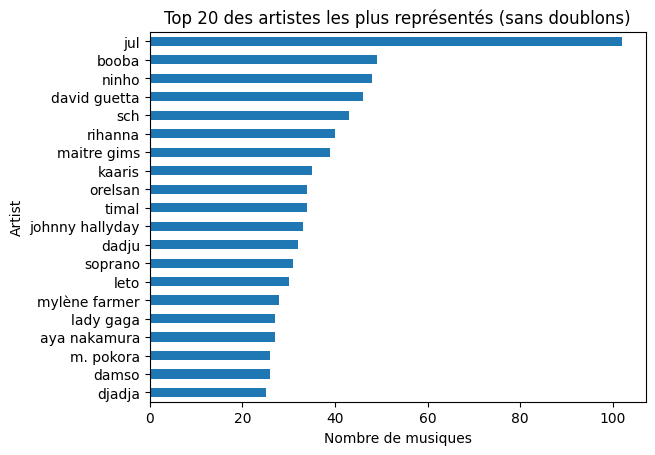

In [166]:
charts_c.groupby("Artist")["Music"].count().sort_values()[-20:].plot.barh()
plt.title("Top 20 des artistes avec le plus de musiques uniques")
plt.xlabel("Nombre de musiques")
plt.show()

Jul est l'artiste avec le plus de musique unique dans le top 100 depuis 2004

# Etape 3 : Scrapping artist data

In [71]:
#Load
artist = pd.read_csv("../etapes/3 - scrapping artist data/artist.csv", encoding="utf-8-sig", index_col=0)

In [72]:
artist.value_counts("Artist_wiki").sort_values() #Aucune page en wiki en double, ce qui est un bon signe !

Artist_wiki
LMC               1
1995 (groupe)     1
2 Chainz          1
24kGoldn          1
2NE1              1
                 ..
Étienne Daho      1
Zkr               1
Yuksek            1
Ysa Ferrer        1
MANUEL           17
Length: 1699, dtype: int64

In [73]:
charts_c = charts.copy().drop(columns=["Rank", "Annee", "Mois"]).drop_duplicates()
charts_c = charts_c.merge(artist, on="Artist", how="left")

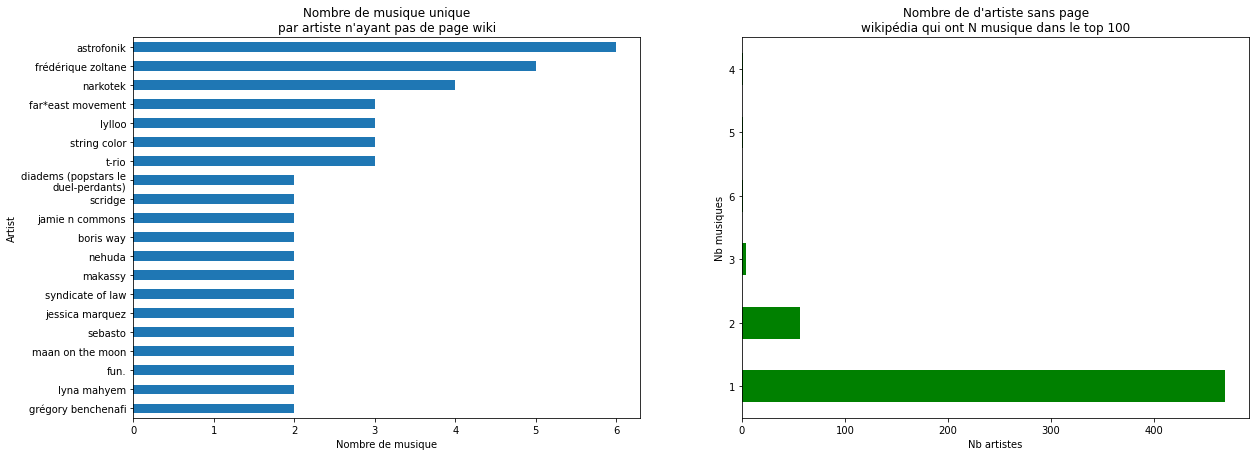

In [74]:
fig, ax = plt.subplots(1, 2, figsize=(20,7))

charts_c[charts_c["Artist_wiki"].isna()].groupby("Artist")["Music"].count().sort_values()[-20:].plot.barh(ax=ax[0])
ax[0].set(title="Nombre de musique unique\npar artiste n'ayant pas de page wiki", xlabel="Nombre de musique")
ax[0].set_yticklabels(["\n".join(wrap(elem.get_text(), 20)) for elem in ax[0].get_yticklabels()])


charts_c[charts_c["Artist_wiki"].isna()].groupby("Artist")["Music"].count().value_counts().plot.barh(ax=ax[1], color="green")
ax[1].set(xlabel="Nb artistes", ylabel="Nb musiques", title="Nombre de d'artiste sans page\nwikipédia qui ont N musique dans le top 100")
plt.show()

On remarque qu'il y a beaucoup d'artistes qui n'ont fait qu'une ou deux musiques populaires, ce qui parait logique de ne pas trouver beaucoup d'information sur eux. </br>
Seul quelques artistes sortent du lot, et après recherche, soit l'artiste n'est pas français, soit il y a trop peu d'infos sur eux.

In [6]:
np.round(artist[artist["Artist_wiki"].isna()].shape[0] / artist.shape[0], 2) # 24% des artistes n'ont pas de page en wiki

0.24

In [80]:
np.round(charts_c[charts_c["Artist_wiki"].isna()].shape[0]/charts_c.shape[0], 2) # 10% des musiques n'ont pas d'info sur leur artistes

0.1

In [82]:
#On recalcul les distances entre les noms d'artistes et les pages wikipédia pour vérifier
def calc_dist(artist, wiki):
    words = ["(chanteur)", "(chanteuse)", "(groupe)", "(rappeur)", "(rappeuse)", "(musicien)", "(chanteur français)", "(france)", "(producteur)", "(artiste)", "(groupe de musique)"]

    if any(w in wiki.lower() for w in words):
        dist = edit_distance(artist.lower().strip(), wiki.lower().split(" (")[0].strip())
        if dist/len(artist) < 0.4:
            return dist
    
    return edit_distance(artist.lower().strip(), wiki.lower().strip())

artist["distance"] = artist.apply(lambda x: calc_dist(x.name, x["Artist_wiki"]), axis=1)
artist["distance_norm"] = artist.apply(lambda x : x["distance"]/len(x.name), axis=1)

AttributeError: 'float' object has no attribute 'lower'

In [83]:
artist[artist["Artist_wiki"] != MISSING].sort_values("distance_norm", ascending=False).head() #Nos distances sont bonnes

KeyError: 'distance_norm'

# Etape 4 : Cleanning wikipedia results

## Nationalité/Pays

In [ ]:
#Load
artist = pd.read_csv("../etapes/4 - cleanning wikipedia results/nationalité_pays/artist.csv", encoding="utf-8-sig", index_col=0)

In [ ]:
artist = artist[artist["Artist_wiki"] != MISSING] #On ne garde que les artistes qui ont une page en wiki

In [ ]:
#Ajout de la colonne "No data" pour voir ceux sur qui on n'a pas de données
artist["No data"] = (
    (artist["Naissance"] == MISSING) &
    (artist["Pays d'origine"] == MISSING) &
    (artist["Origine"] == MISSING) &
    (artist["Nationalité"] == MISSING) &
    (artist["Pays"] == MISSING) &
    (artist["Summary"] == MISSING)
)

In [ ]:
chart_c = charts.copy().merge(artist, left_on="Artist", right_on="Artist", how="right")

In [ ]:
chart_c[chart_c["No data"]].groupby("Artist")["Music"].count().sort_values(ascending=False)[:20]

In [ ]:
ancien_data = []
for col in ["Pays", "Origine", "Nationalité", "Pays d'origine"]:
    ancien_data.append(artist[col].value_counts().drop(index=[MISSING]))

In [ ]:
artist = artist[~artist["No data"]] #On ne garde que les artistes pour lesquels on a des données

In [ ]:
def get_nationality(row, words):
    for r in words:
        regex = r"([\d)()\] ]|^)"+ r.lower() + r"([.,\[) ]|$)"

        if not re.search(regex, row["Summary"].lower()) is None:
            return r.lower()
    return MISSING

In [ ]:
#On utilise le summary pour récupérer la nationalité
avant = artist[artist["Nationalité"] == MISSING].shape[0]

artist.loc[artist["Nationalité"] == MISSING, "Nationalité"] = artist[artist["Nationalité"] == MISSING].apply(lambda x: get_nationality(x, artist["Nationalité"].unique()), axis=1)

apres = artist[artist["Nationalité"] == MISSING].shape[0]

print(avant - apres) #On a récupéré 56 nationalités

In [ ]:
def get_pays(row, words):
    for r in words:
        regex = r"([\d)()\], ]|^)"+ r.lower() + r"([.,\[) ]|$)"

        if not re.search(regex, row["Naissance"].lower()) is None:
            return r.lower()
    return MISSING

In [ ]:
# On récupére une liste de pays
gentille_df = pd.read_csv("../monde/gentille.csv")
pays = gentille_df["pays"].tolist()

In [ ]:
#On utilise le summary pour récupérer la Pays
avant = artist[artist["Pays"] == MISSING].shape[0]

artist.loc[artist["Pays"] == MISSING, "Pays"] = artist[artist["Pays"] == MISSING].apply(lambda x: get_pays(x, pays), axis=1)

apres = artist[artist["Pays"] == MISSING].shape[0]

print(avant - apres) #On a récupéré 520 Pays

In [ ]:
avant = artist[artist["Nationalité"] == MISSING].shape[0]

In [ ]:
#On récupère la nationalité à partir du pays
gentille = pd.DataFrame.to_dict(gentille_df.set_index("pays"), orient="dict").get("gentille")

for k, v in gentille.items():
    artist.loc[(artist["Nationalité"] == MISSING) & (artist["Pays"] == k), "Nationalité"] = v
    artist.loc[(artist["Nationalité"] == MISSING) & (artist["Pays d'origine"] == k), "Nationalité"] = v

In [ ]:
# Les origines sont transposées avec sur la nationalité
artist.loc[(artist["Nationalité"] == MISSING) & (artist["Origine"] != MISSING), "Nationalité"] = artist.loc[(artist["Nationalité"] == MISSING) & (artist["Origine"] != MISSING), "Origine"]

In [ ]:
apres = artist[artist["Nationalité"] == MISSING].shape[0]
print(avant - apres) #On a récupéré 486 nationalités

In [ ]:
data_to_plot = []
for data, col in zip(ancien_data, ["Pays", "Origine", "Nationalité", "Pays d'origine"]):
    data_to_plot.append(data)
    data_to_plot.append(artist[col].value_counts().drop(index=[MISSING]))

In [ ]:
titles = ["Ancien", "Nouveau"]
k = 0
fig, ax = plt.subplots(4, 2, figsize=(25, 70))
for axi, data in zip(ax.flatten(), data_to_plot):
    data.plot.barh(ax=axi)
    axi.set(xlabel="Nombre d'artistes")
    axi.set_title(titles[k%2], size=20)
    k += 1

titles = ["Pays", "Origine", "Nationalité", "Pays d'origine"]
for axi, title in zip(ax[:,0], titles):
    axi.set_ylabel(title, size=25)

In [ ]:
artist[(artist["Nationalité"] == MISSING) & (artist["Naissance"] != MISSING)].to_csv("../artist_missing.csv", encoding="utf-8-sig")

In [ ]:
chart_c = chart.copy().merge(artist, left_on="Artist", right_on="Artist", how="left")

In [ ]:
chart_c[chart_c["Nationalité"] == MISSING].groupby("Artist")["Music"].count().sort_values(ascending=False)

Artist
tayc              20
soso maness       15
eddy de pretto     6
inna               6
lily allen         6
                  ..
havana brown       1
gusttavo lima      1
grand galop        1
gomez              1
kiss               1
Name: Music, Length: 172, dtype: int64

## Departement/Region/Commune

In [ ]:
#Load
artist = pd.read_csv("../etapes/4 - cleanning wikipedia results/departement_region/artist.csv", encoding="utf-8-sig", index_col=0)

In [ ]:
region = pd.read_csv("../france/departements-france.csv")
departement = pd.read_csv("../france/departements-france.csv")
commune = pd.read_csv("../france/communes-departement-region.csv")
nb_habitant = pd.read_csv("../france/nb_habitant.csv")

In [ ]:
#On supprime les colonnes inutiles
commune = commune.drop(columns = ["code_commune_INSEE", "nom_commune_postal", "code_postal", "libelle_acheminement", "ligne_5", "latitude", "longitude", "code_commune", "article", "code_departement", "code_region", "nom_commune"])

#On rename la colonne nom_commune_complet en nom_commune
commune = commune.rename(columns={"nom_commune_complet": "nom_commune"})

#On enleve les arrondisement des villes
commune.loc[commune["nom_commune"].str.contains(r"[A-Za-z]* [0-9]{2}"), "nom_commune"] = commune.loc[commune["nom_commune"].str.contains(r"[A-Za-z]* [0-9]{2}"), "nom_commune"].str[:-3]

#On ajoute le nombre d'habitant au commune
commune = commune.merge(nb_habitant[["Ville", "nb_habitant"]], left_on="nom_commune", right_on="Ville", how="inner").drop(columns=["Ville"]).dropna().drop_duplicates()

#On transforme le nb d'habitant en int
commune["nb_habitant"] = commune["nb_habitant"].str.replace(" ", "")
commune["nb_habitant"] = commune["nb_habitant"].astype("int")

#On transforme tout en lower
for col in commune.select_dtypes("object").columns:
    commune[col] = commune[col].str.lower()

In [ ]:
def get_localisation(row, localisation):
    for r in localisation:
        regex = r"([\d)()\] ]|^)"+ r.lower() + r"([.,\[) ]|$)"

        if (not re.search(regex, row["Summary"].lower()) is None) or (not re.search(regex, row["Naissance"].lower()) is None):
            return r.lower()
    return MISSING

In [ ]:
artist["Region"] = artist.apply(lambda x: get_localisation(x, commune["nom_region"]), axis=1)

In [ ]:
artist["Commune"] = artist.apply(lambda x: get_localisation(x, commune[commune["nb_habitant"] > 2000]["nom_commune"]), axis=1)

In [ ]:
artist["Departement"] = artist.apply(lambda x: get_localisation(x, commune["nom_departement"]), axis=1)

In [ ]:
for col in ["Region", "Commune", "Departement"]:
    print("-"*50)
    print(col)
    print("-"*50)
    print(artist[col].value_counts().drop(index=[MISSING]))
    print("Total : ", artist[col].value_counts()[1:].sum())

--------------------------------------------------
Region
--------------------------------------------------
guadeloupe                    7
guyane                        5
bretagne                      3
provence-alpes-côte d'azur    3
martinique                    3
normandie                     2
hauts-de-france               2
la réunion                    1
corse                         1
pays de la loire              1
île-de-france                 1
Name: Region, dtype: int64
Total :  29
--------------------------------------------------
Commune
--------------------------------------------------
paris          80
marseille      21
nice           11
lyon            8
saint-denis     7
               ..
courbevoie      1
pontoise        1
lens            1
colomiers       1
yerres          1
Name: Commune, Length: 210, dtype: int64
Total :  439
--------------------------------------------------
Departement
--------------------------------------------------
paris                85


In [ ]:
artist["No localisation"] = (
    (artist["Region"] == MISSING) &
    (artist["Commune"] == MISSING) &
    (artist["Departement"] == MISSING)
)

In [ ]:
# Les artistes pour qui ont a trouvé une commune/departement/region on leur donne la nationalité française
artist.loc[(artist["Nationalité"] == MISSING) & (~artist["No localisation"]), "Nationalité"] = "français"

In [ ]:
def commune_to_departement(x : str):
    value = commune.loc[commune["nom_commune"] == x, "nom_departement"].values
    if len(value) > 0:
        return value[0]
    else:
        return MISSING

In [ ]:
#On ajoute les departements pour les communes
artist.loc[(artist["Commune"] != MISSING) & (artist["Departement"] == MISSING), "Departement"] = artist.loc[(artist["Commune"] != MISSING) & (artist["Departement"] == MISSING), "Commune"].apply(commune_to_departement)

In [ ]:
def departement_to_region(x : str):
    value = commune.loc[commune["nom_departement"] == x, "nom_region"].values
    if len(value) > 0:
        return value[0]
    else:
        return MISSING

In [ ]:
#On ajoute les regions pour les departements
artist.loc[(artist["Departement"] != MISSING) & (artist["Region"] == MISSING), "Region"] = artist.loc[(artist["Departement"] != MISSING) & (artist["Region"] == MISSING), "Departement"].apply(departement_to_region)

In [ ]:
artist["No localisation"] = (
    (artist["Region"] == MISSING) &
    (artist["Commune"] == MISSING) &
    (artist["Departement"] == MISSING)
)

In [ ]:
artist[artist["No localisation"]].to_csv("../artist_no_localisation.csv", encoding="utf-8-sig")

In [ ]:
artist[artist["No localisation"]].value_counts("Nationalité")

Nationalité
                151
français        148
américains      137
néerlandais     134
britanniques    125
               ... 
bosniaques        1
biélorusses       1
guinéens          1
panaméens         1
ivoiriens         1
Length: 81, dtype: int64